In [1]:
### Neural Operator Project - Jupyter Notebook

# **Introduction**
# This notebook demonstrates how to use Neural Operators, specifically Fourier Neural Operators (FNO),
# for mapping coarse-resolution data to fine-resolution predictions. The project uses wind speed data
# from an ERA5 dataset covering the Indian region.

In [2]:
### Environment Setup
# Install required libraries (uncomment the following line if needed)
#!pip install numpy matplotlib torch xarray

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import xarray as xr

In [3]:
### Data Loading and Preprocessing
# Load the NetCDF dataset
#!pip install netCDF4 h5netcdf

file_path = "ERA5_India_weather_data.nc"  # Update this path if needed
data = xr.open_dataset(file_path)

# Display dataset structure
print(data)

<xarray.Dataset>
Dimensions:     (valid_time: 372, latitude: 119, longitude: 117)
Coordinates:
    number      int64 ...
  * valid_time  (valid_time) datetime64[ns] 2024-01-01 ... 2024-10-31T18:00:00
  * latitude    (latitude) float64 37.5 37.25 37.0 36.75 ... 8.75 8.5 8.25 8.0
  * longitude   (longitude) float64 68.0 68.25 68.5 68.75 ... 96.5 96.75 97.0
    expver      (valid_time) object ...
Data variables:
    u10         (valid_time, latitude, longitude) float32 ...
    v10         (valid_time, latitude, longitude) float32 ...
    t2m         (valid_time, latitude, longitude) float32 ...
    msl         (valid_time, latitude, longitude) float32 ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-01-24T09:13 GRIB to CDM+CF via c

In [4]:
# Variables in the dataset:
# - u10: Eastward wind component at 10m
# - v10: Northward wind component at 10m
# - t2m: 2m temperature
# - msl: Mean sea level pressure

# Calculate wind speed from u10 and v10
u10 = data['u10']
v10 = data['v10']
wind_speed = (u10**2 + v10**2)**0.5  # Magnitude of wind speed

# Add wind speed to the dataset
data['wind_speed'] = wind_speed

# Display summary of wind speed
print(data['wind_speed'])

<xarray.DataArray 'wind_speed' (valid_time: 372, latitude: 119, longitude: 117)>
array([[[1.8876371 , 2.0227761 , 1.8959234 , ..., 2.425375  ,
         2.7391717 , 2.7156577 ],
        [2.0339599 , 1.2753962 , 1.5793898 , ..., 2.2629316 ,
         2.1509306 , 2.3457794 ],
        [2.2523975 , 2.412777  , 1.999028  , ..., 2.1702883 ,
         1.3131971 , 2.00226   ],
        ...,
        [5.1703153 , 5.4518795 , 5.761484  , ..., 5.258156  ,
         5.036731  , 4.7892585 ],
        [5.606739  , 5.786163  , 5.93403   , ..., 4.586233  ,
         4.3061223 , 4.21897   ],
        [5.8265624 , 5.899008  , 5.9906483 , ..., 4.0007014 ,
         3.7406483 , 3.868475  ]],

       [[1.5060605 , 1.2649623 , 1.4729277 , ..., 3.3940318 ,
         2.4390128 , 1.9866458 ],
        [1.7300614 , 1.2433519 , 1.1439027 , ..., 1.3184494 ,
         1.5710573 , 1.3475783 ],
        [2.3555424 , 2.0702734 , 1.6662705 , ..., 1.8648083 ,
         1.6535848 , 1.584049  ],
...
        [2.2374768 , 2.2601573 , 2.4

In [5]:
### Data Subsetting and Analysis
# Subset data for a specific region and time range
# Focus on a smaller time period to reduce dataset size if needed
data_subset = data.sel(
    valid_time=slice("2024-01-01", "2024-01-31"),  # January 2024
    latitude=slice(37.5, 8.0),  # Entire latitude range
    longitude=slice(68.0, 97.0)  # Entire longitude range
)

# Aggregate data to daily averages
daily_wind_speed = data_subset['wind_speed'].resample(valid_time="1D").mean()

# Display subset details
print("Subset data dimensions:", daily_wind_speed.shape)

Subset data dimensions: (31, 119, 117)


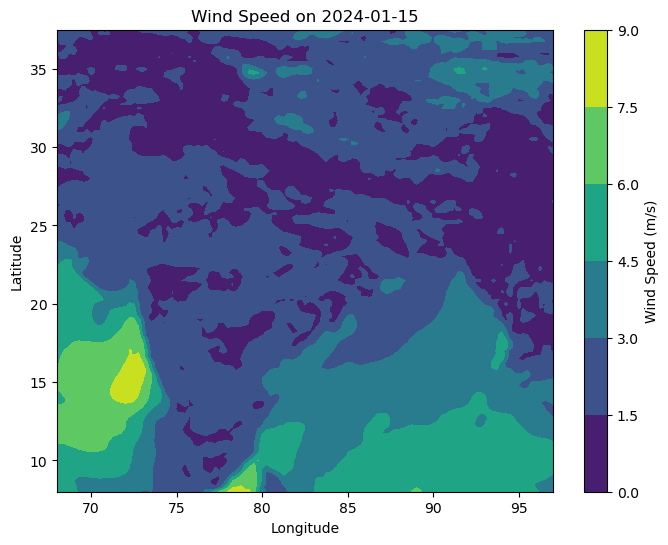

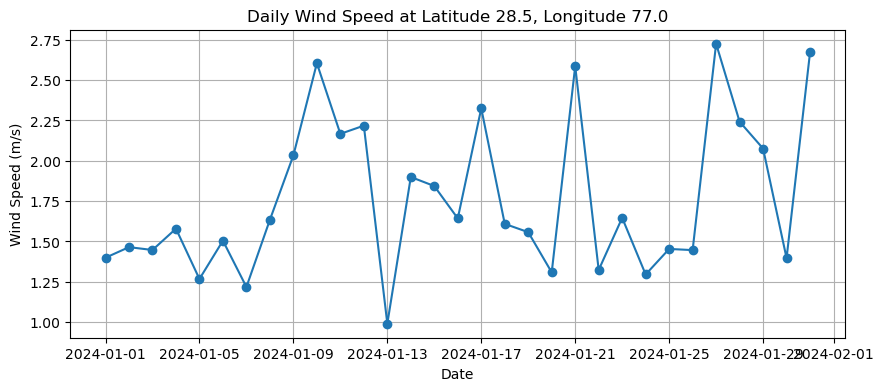

In [6]:
### Data Visualization
# Plot wind speed for a specific day
specific_day = daily_wind_speed.sel(valid_time="2024-01-15")
plt.figure(figsize=(8, 6))
plt.title("Wind Speed on 2024-01-15")
plt.contourf(specific_day.longitude, specific_day.latitude, specific_day, cmap="viridis")
plt.colorbar(label="Wind Speed (m/s)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

# Plot time series of wind speed for a specific location
specific_location = daily_wind_speed.sel(latitude=28.5, longitude=77.0, method="nearest")
plt.figure(figsize=(10, 4))
plt.title("Daily Wind Speed at Latitude 28.5, Longitude 77.0")
plt.plot(specific_location.valid_time, specific_location, marker="o")
plt.xlabel("Date")
plt.ylabel("Wind Speed (m/s)")
plt.grid()
plt.show()

In [7]:
### Preparing Data for Neural Operators
# Coarse and Fine Grid Preparation
coarse_wind = daily_wind_speed.coarsen(latitude=4, longitude=4, boundary="pad").mean()
fine_wind = daily_wind_speed

# Convert to PyTorch Tensors
coarse_tensor = torch.tensor(coarse_wind.values, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
fine_tensor = torch.tensor(fine_wind.values, dtype=torch.float32).unsqueeze(0).unsqueeze(0)

# Display tensor shapes
print("Coarse tensor shape:", coarse_tensor.shape)
print("Fine tensor shape:", fine_tensor.shape)

# Save tensors for later use
torch.save(coarse_tensor, "coarse_wind_tensor.pt")
torch.save(fine_tensor, "fine_wind_tensor.pt")

Coarse tensor shape: torch.Size([1, 1, 31, 30, 30])
Fine tensor shape: torch.Size([1, 1, 31, 119, 117])


## Model definition and training

In [8]:
# Define Fourier Neural Operator (FNO) with spatial alignment
class SimpleFNO2D(nn.Module):
    def __init__(self, modes, width):
        super(SimpleFNO2D, self).__init__()
        self.modes = modes
        self.width = width

        # Adjust input layer to handle 1 channel -> width channels
        self.fc0 = nn.Conv2d(1, self.width, kernel_size=1)  # Input: 1 channel → width channels

        # Convolution layers for processing
        self.conv1 = nn.Conv2d(self.width, self.width, kernel_size=1)
        self.conv2 = nn.Conv2d(self.width, self.width, kernel_size=1)

        # Upsampling layer to match fine spatial resolution
        self.upsample = nn.Upsample(size=(119, 117), mode="bilinear", align_corners=True)

        # Final output layer
        self.fc1 = nn.Conv2d(self.width, 1, kernel_size=1)  # Output: width channels → 1 channel

    def forward(self, x):
        # Input: (batch, channels, time_steps, height, width)
        batch_size, channels, time_steps, height, width = x.shape

        # Reshape for convolutional processing
        x = x.view(batch_size * time_steps, channels, height, width)  # Combine batch and time dimensions
        x = self.fc0(x)  # Map input channel to width channels
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))

        # Upsample to match fine spatial resolution
        x = self.upsample(x)

        # Final output mapping to single channel
        x = self.fc1(x)

        # Reshape back to (batch, time_steps, channels, height, width)
        x = x.view(batch_size, time_steps, 1, x.shape[-2], x.shape[-1])
        return x

# Initialize model, optimizer, and loss function
modes = 16
width = 32
model = SimpleFNO2D(modes, width)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    # Forward pass
    predictions = model(coarse_tensor)

    # Align dimensions of predictions with fine_tensor
    predictions = predictions.permute(0, 2, 1, 3, 4)  # Align time and channel axes

    # Compute loss
    loss = loss_fn(predictions, fine_tensor)
    loss.backward()

    # Update weights
    optimizer.step()

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

### Model Evaluation
model.eval()
with torch.no_grad():
    # Predict fine-resolution data
    predicted_fine = model(coarse_tensor).detach().numpy()

Epoch 0, Loss: 10.6310
Epoch 10, Loss: 6.2590
Epoch 20, Loss: 2.0592
Epoch 30, Loss: 0.3491
Epoch 40, Loss: 0.5305


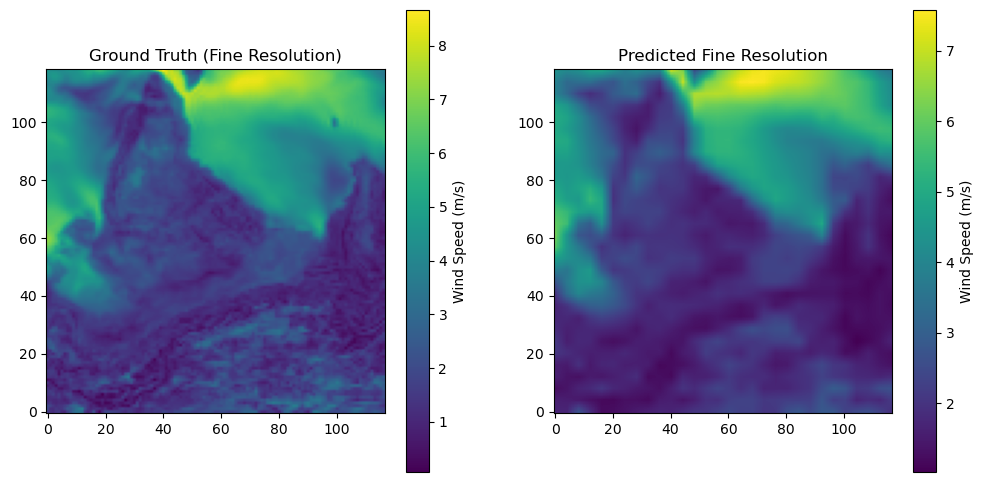

In [9]:
# Visualize results
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Ground Truth (Fine Resolution)")
plt.imshow(fine_tensor.squeeze().numpy()[0], origin="lower", cmap="viridis")
plt.colorbar(label="Wind Speed (m/s)")

plt.subplot(1, 2, 2)
plt.title("Predicted Fine Resolution")
plt.imshow(predicted_fine.squeeze()[0], origin="lower", cmap="viridis")
plt.colorbar(label="Wind Speed (m/s)")
plt.show()

In [10]:
mae = torch.mean(torch.abs(predictions - fine_tensor)).item()
print(f"Mean Absolute Error: {mae:.4f}")

Mean Absolute Error: 0.4128


In [11]:
region_mae = torch.mean(torch.abs(predictions - fine_tensor), dim=(0, 3, 4))  # MAE for each region
print("Region-wise MAE:", region_mae)

Region-wise MAE: tensor([[0.3893, 0.3953, 0.4120, 0.4179, 0.4299, 0.4395, 0.4621, 0.4669, 0.4960,
         0.4532, 0.4396, 0.4354, 0.4326, 0.3976, 0.3561, 0.3875, 0.3564, 0.3790,
         0.4027, 0.4048, 0.3757, 0.4109, 0.4280, 0.3791, 0.3895, 0.4164, 0.4097,
         0.4237, 0.4053, 0.4135, 0.3908]], grad_fn=<MeanBackward1>)


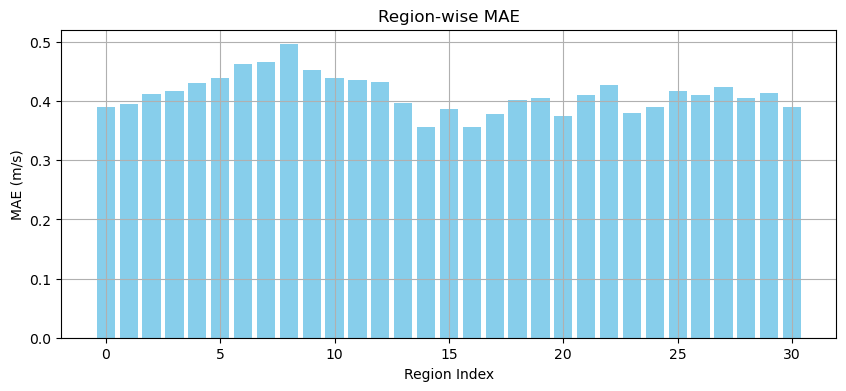

In [12]:
region_mae_np = region_mae.squeeze().detach().numpy()  # Use detach() to avoid gradient tracking

# Plot region-wise MAE as a bar chart
plt.figure(figsize=(10, 4))
plt.bar(range(len(region_mae_np)), region_mae_np, color='skyblue')
plt.title("Region-wise MAE")
plt.xlabel("Region Index")
plt.ylabel("MAE (m/s)")
plt.grid()
plt.show()

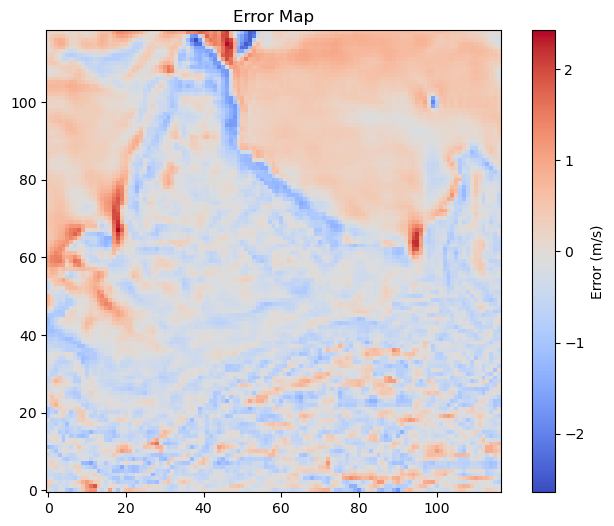

In [13]:
error_map = fine_tensor.squeeze().numpy()[0] - predicted_fine.squeeze()[0]
plt.figure(figsize=(8, 6))
plt.title("Error Map")
plt.imshow(error_map, origin="lower", cmap="coolwarm")
plt.colorbar(label="Error (m/s)")
plt.show()

In [14]:
torch.save(model.state_dict(), "simple_fno2d_model.pth")
print("Model saved as 'simple_fno2d_model.pth'")

Model saved as 'simple_fno2d_model.pth'


## Testing new data on our model

In [15]:
# Load the new dataset
new_file_path = "jan_2025_testing.nc"
new_data = xr.open_dataset(new_file_path)

# Extract wind components and calculate wind speed
new_u10 = new_data['u10']
new_v10 = new_data['v10']
new_wind_speed = (new_u10**2 + new_v10**2)**0.5  # Magnitude of wind speed

# Subset the data for the desired region and time
new_subset = new_wind_speed.sel(
    valid_time=slice("2025-01-01", "2025-01-31"),
    latitude=slice(37.5, 8.0),
    longitude=slice(68.0, 97.0)
)

# Downscale to coarse grid
new_coarse_wind = new_subset.coarsen(latitude=4, longitude=4, boundary="pad").mean()

# Convert to PyTorch tensor
new_coarse_tensor = torch.tensor(new_coarse_wind.values, dtype=torch.float32).unsqueeze(0).unsqueeze(1)

# Display tensor shape
print("New Coarse Tensor Shape:", new_coarse_tensor.shape)

New Coarse Tensor Shape: torch.Size([1, 1, 72, 30, 30])


In [16]:
# Load the trained model
model = SimpleFNO2D(modes=16, width=32)
model.load_state_dict(torch.load("simple_fno2d_model.pth"))  # Adjust the path if needed
model.eval()  # Set the model to evaluation mode

SimpleFNO2D(
  (fc0): Conv2d(1, 32, kernel_size=(1, 1), stride=(1, 1))
  (conv1): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
  (upsample): Upsample(size=(119, 117), mode='bilinear')
  (fc1): Conv2d(32, 1, kernel_size=(1, 1), stride=(1, 1))
)

In [17]:
# Predict fine-resolution data for January 2025
with torch.no_grad():
    new_predictions = model(new_coarse_tensor)

# Detach and convert predictions to NumPy
new_predicted_fine = new_predictions.squeeze().detach().numpy()

# Display prediction shape
print("Predicted Fine Resolution Shape:", new_predicted_fine.shape)

Predicted Fine Resolution Shape: (72, 119, 117)


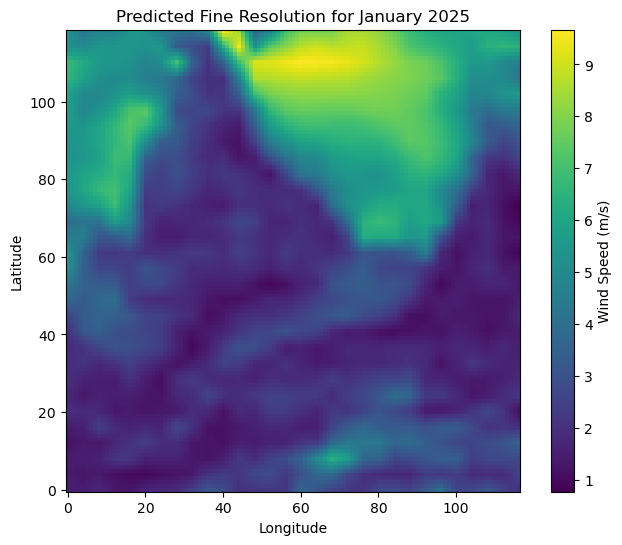

In [18]:
# Visualize the predicted fine resolution wind speed
plt.figure(figsize=(8, 6))
plt.title("Predicted Fine Resolution for January 2025")
plt.imshow(new_predicted_fine[0], origin="lower", cmap="viridis")
plt.colorbar(label="Wind Speed (m/s)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [19]:
# Assume new_fine_tensor is the ground truth fine-resolution data for January 2025
new_fine_tensor = torch.tensor(new_subset.values, dtype=torch.float32).unsqueeze(0).unsqueeze(1)

# Compute the MAE
mae = torch.mean(torch.abs(torch.tensor(new_predicted_fine) - new_fine_tensor)).item()
print(f"Mean Absolute Error for January 2025: {mae:.4f}")

Mean Absolute Error for January 2025: 0.5568


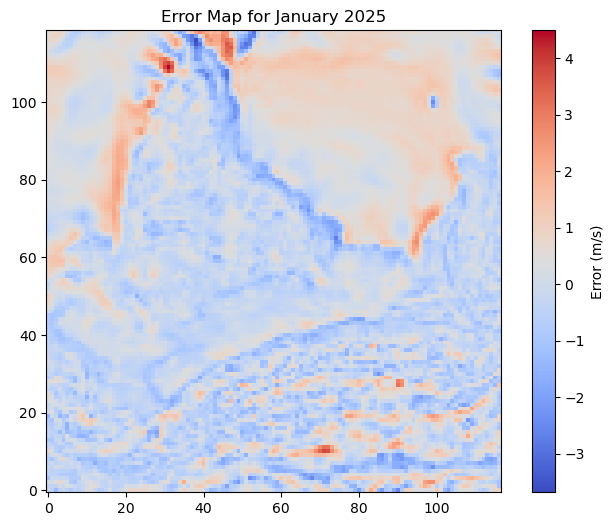

In [20]:
error_map = new_fine_tensor.squeeze().numpy()[0] - new_predicted_fine.squeeze()[0]
plt.figure(figsize=(8, 6))
plt.title("Error Map for January 2025")
plt.imshow(error_map, origin="lower", cmap="coolwarm")
plt.colorbar(label="Error (m/s)")
plt.show()